In [2]:
!pip install sqlalchemy statsmodels numpy

In [3]:
!pip install pandas matplotlib seaborn

In [4]:
# Importar librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings
warnings.filterwarnings('ignore')

In [5]:
# Cargar los datos desde el archivo CSV
file_path = "../data/WEB.csv"
df_web = pd.read_csv(file_path, sep=',')

# Convertir la columna 'ID_Date' a formato de fecha con el formato correcto
df_web['ID_Date'] = pd.to_datetime(df_web['ID_Date'], format='%Y%m')


# Convertir la columna 'Date' a tipo datetime y establecerla como índice
df_web['ID_Date'] = pd.to_datetime(df_web['ID_Date'], format='%d.%m.%Y')
df_web.set_index('ID_Date', inplace=True)

# Convertir los datos diarios a datos mensuales tomando el primer día de cada mes
df_monthly = df_web.resample('MS').mean().asfreq('MS')

# Filtrar todas las filas donde 'Revenue' no sea nulo o NaN
df_monthly_filtered = df_monthly.dropna(subset=['Unique_visitors'])


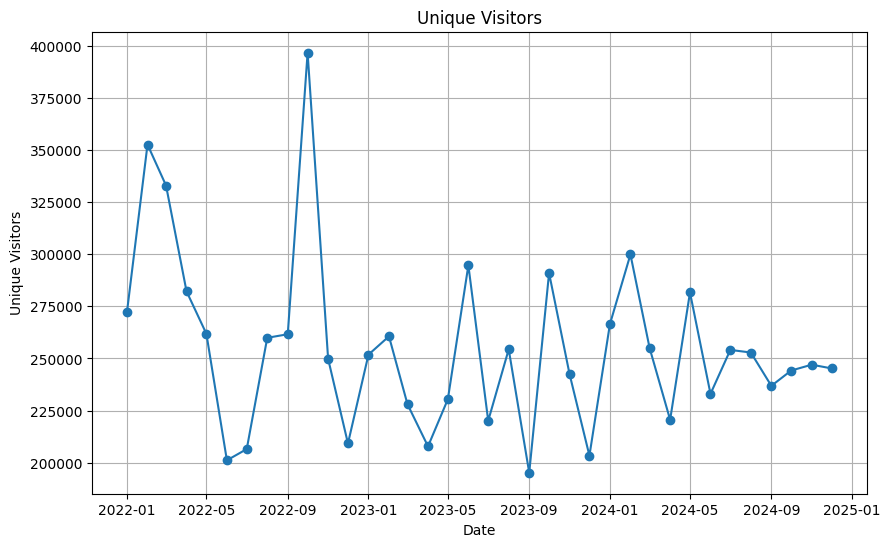

In [6]:
# Graficar la columna 'Revenue'
plt.figure(figsize=(10, 6))
plt.plot(df_web.index, df_web['Unique_visitors'], marker='o', linestyle='-')
plt.title('Unique Visitors')
plt.xlabel('Date')
plt.ylabel('Unique Visitors')
plt.grid(True)
plt.show()

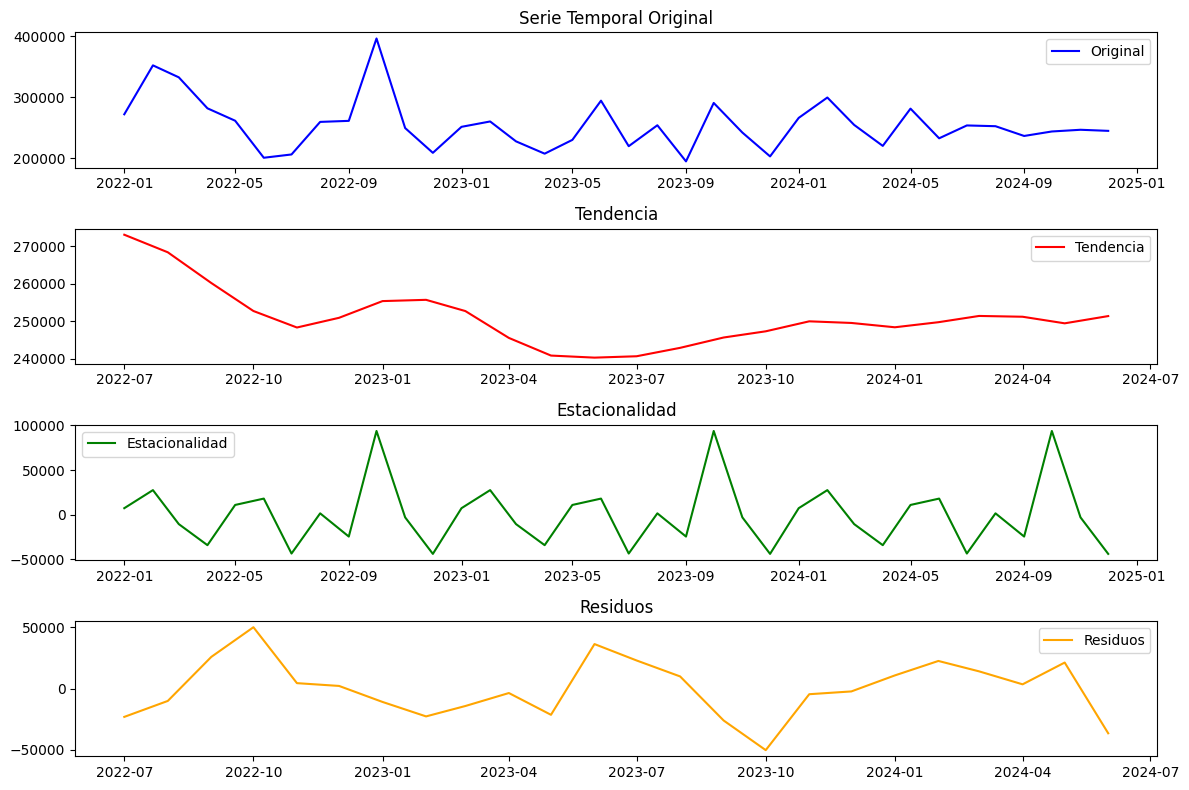

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose


# Asegurarse de que el índice sea un DatetimeIndex
if not isinstance(df_web.index, pd.DatetimeIndex):
	df_web.index = pd.to_datetime(df_web.index)

# Descomposición de la serie temporal
decomposition = seasonal_decompose(df_web['Unique_visitors'], model='additive', period=12)

# Obtención de las componentes
trend = decomposition.trend
seasonal = decomposition.seasonal
residuals = decomposition.resid

# Graficar las componentes
plt.figure(figsize=(12, 8))

plt.subplot(411)
plt.plot(df_web['Unique_visitors'], label='Original', color='blue')
plt.legend()
plt.title('Serie Temporal Original')

plt.subplot(412)
plt.plot(trend, label='Tendencia', color='red')
plt.legend()
plt.title('Tendencia')

plt.subplot(413)
plt.plot(seasonal, label='Estacionalidad', color='green')
plt.legend()
plt.title('Estacionalidad')

plt.subplot(414)
plt.plot(residuals, label='Residuos', color='orange')
plt.legend()
plt.title('Residuos')

plt.tight_layout()
plt.show()

In [8]:
# Dividir los datos en conjunto de entrenamiento y conjunto de prueba (80% entrenamiento, 20% prueba)
train_size = int(len(df_monthly_filtered) * 0.8)
train, test = df_monthly_filtered.iloc[:train_size], df_monthly_filtered.iloc[train_size:]

In [9]:
import pandas as pd
from pmdarima import auto_arima

# Establecer la frecuencia de los datos (por ejemplo, 'D' para diario, 'M' para mensual, 'Y' para anual)
frequency = 'MS'  # Por ejemplo, si los datos son mensuales

# Definir el número de períodos en una temporada (ajustar según sea necesario)
seasonal_periods = 12  # Por ejemplo, si los datos son mensuales y tienen estacionalidad anual

# Supongamos que df contiene múltiples columnas y deseamos modelar solo una de ellas
serie_temporal = df_monthly_filtered['Unique_visitors']  # Reemplaza 'nombre_de_la_columna' con el nombre de la columna que deseas modelar

model = auto_arima(serie_temporal,
                   seasonal=True,
                   m=12,
                   d=1,
                   D=1,
                   start_p=0,
                   start_q=0,
                   start_P=0,
                   start_Q=0,
                   max_p=3,
                   max_q=3,
                   max_P=2,
                   max_Q=2,
                   stepwise=True,
                   trace=True,
                   error_action='ignore',
                   suppress_warnings=True)

# Imprimir los mejores hiperparámetros encontrados por auto_arima
print("Mejores hiperparámetros SARIMA:", model.get_params())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=576.683, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=570.520, Time=0.11 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=567.595, Time=0.14 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=575.776, Time=0.04 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=569.581, Time=0.20 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=569.569, Time=0.25 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=571.231, Time=0.11 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=571.389, Time=0.76 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=566.236, Time=0.08 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=568.221, Time=0.17 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=567.779, Time=0.17 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=569.625, Time=0.08 sec
 ARIMA(0,1,0)(1,1,2)[12]             : AIC=569.503, Time=0.48 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=566.364, Time=0.14 sec
 ARIMA(1,1,1)(0,1,1)[12]         

count        36.000000
mean     255653.500000
std       42557.597755
min      195193.000000
25%      229823.000000
50%      252340.500000
75%      267961.500000
max      396642.000000
Name: Unique_visitors, dtype: float64


<Axes: xlabel='ID_Date'>

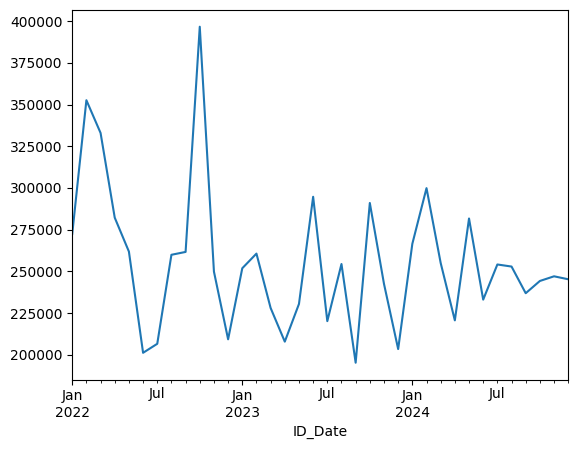

In [10]:
print(serie_temporal.describe())
serie_temporal.plot()

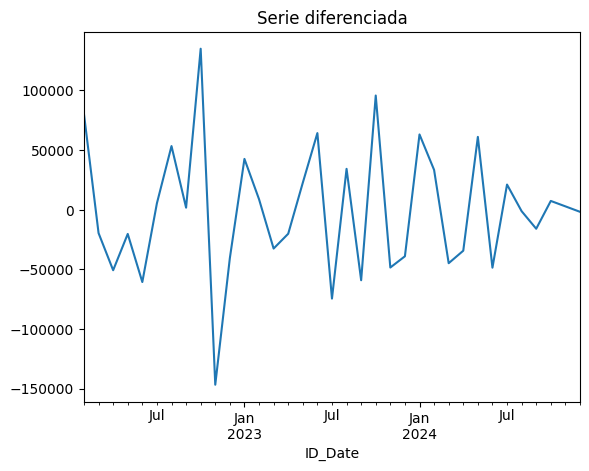

In [11]:
# Diferenciación no estacional (d=1)
serie_diff = serie_temporal.diff().dropna()

# Visualízala
serie_diff.plot(title='Serie diferenciada')
plt.show()


Métricas del Modelo SARIMA (0, 1, 0)(0, 1, 1, 12): (1513697975.405023, 34394.379175436254, 38906.27167186575, -6.814320573918666)


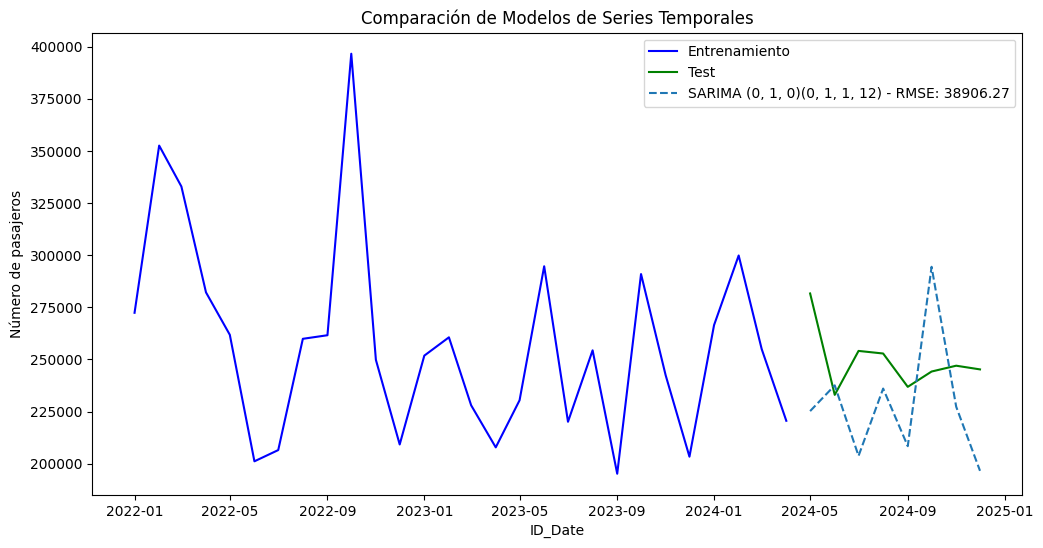

ARIMA - AIC: 367.87248336250656 BIC: 369.28858376471095
SARIMA - AIC: 367.87248336250656 BIC: 369.28858376471095

Coeficientes SARIMA (0, 1, 0)(0, 1, 1, 12):
                                      SARIMAX Results                                       
Dep. Variable:                      Unique_visitors   No. Observations:                   28
Model:             SARIMAX(0, 1, 0)x(0, 1, [1], 12)   Log Likelihood                -181.936
Date:                              Fri, 11 Apr 2025   AIC                            367.872
Time:                                      15:37:52   BIC                            369.289
Sample:                                  01-01-2022   HQIC                           367.857
                                       - 04-01-2024                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
-------------------

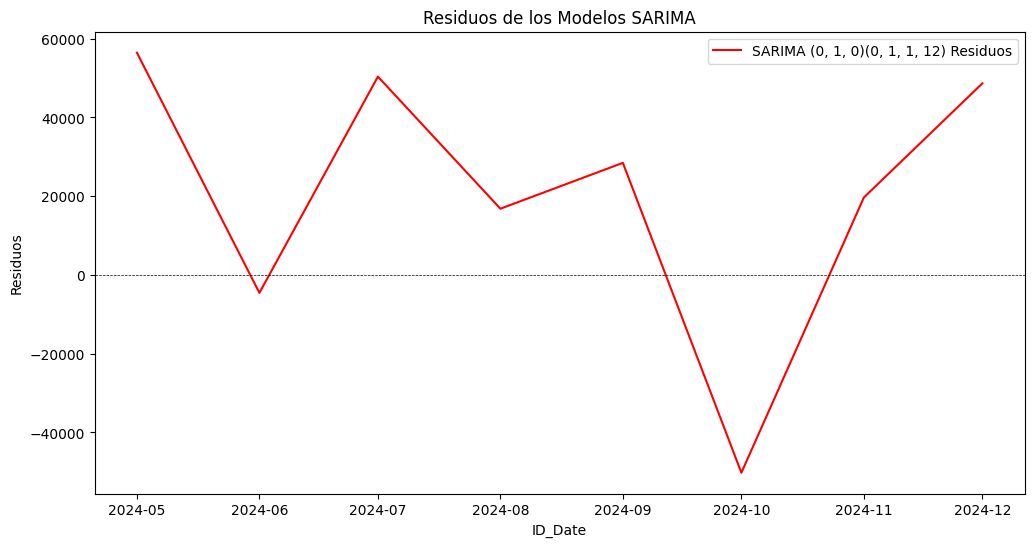

              ID_Date  SARIMA (0, 1, 0)(0, 1, 1, 12) Residuos
ID_Date                                                      
2024-05-01 2024-05-01                            56425.422307
2024-06-01 2024-06-01                            -4562.097581
2024-07-01 2024-07-01                            50355.685973
2024-08-01 2024-08-01                            16810.620291
2024-09-01 2024-09-01                            28454.749092
2024-10-01 2024-10-01                           -50236.655688
2024-11-01 2024-11-01                            19661.077645
2024-12-01 2024-12-01                            48648.724827


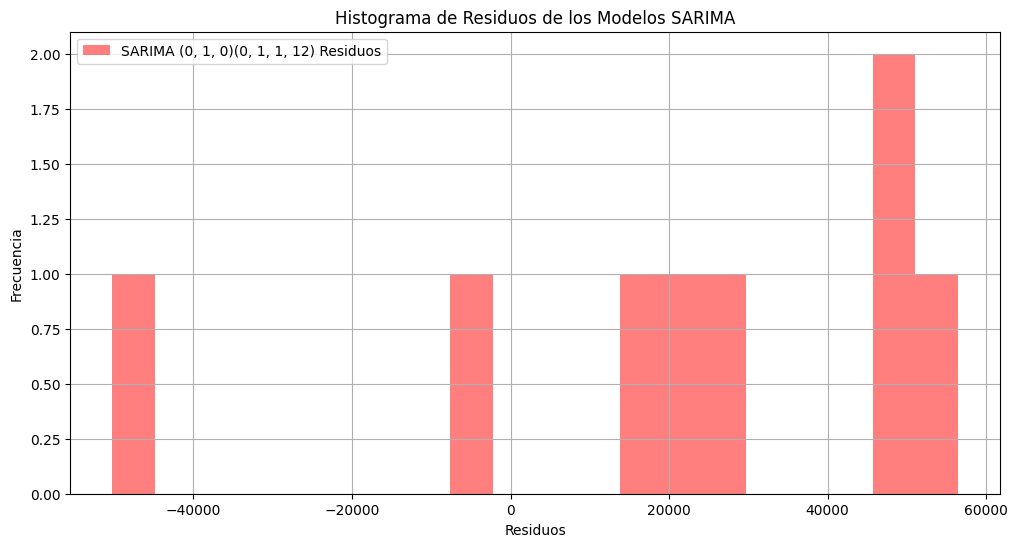

In [12]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Ajustar y predecir el modelo SARIMA
sarima_model2 = SARIMAX(train['Unique_visitors'], order=(0, 1, 0), seasonal_order=(0, 1, 1, 12))
sarima_fit2 = sarima_model2.fit()
sarima_predictions2 = sarima_fit2.predict(start=len(train), end=len(train) + len(test) - 1, typ='levels')

# Calcular métricas de validación para cada modelo
def calcular_metricas(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    return mse, mae, rmse, r2

# Calculamos las métricas para cada modelo

sarima_metrics2 = calcular_metricas(test['Unique_visitors'], sarima_predictions2)

# Imprimir las métricas

print("Métricas del Modelo SARIMA (0, 1, 0)(0, 1, 1, 12):", sarima_metrics2)

# Graficar los resultados
plt.figure(figsize=(12, 6))
plt.plot(train.index, train['Unique_visitors'], label='Entrenamiento', color='blue')
plt.plot(test.index, test['Unique_visitors'], label='Test', color='green')

plt.plot(test.index, sarima_predictions2, label=f'SARIMA (0, 1, 0)(0, 1, 1, 12) - RMSE: {sarima_metrics2[2]:.2f}', linestyle='--')
plt.xlabel('ID_Date')
plt.ylabel('Número de pasajeros')
plt.title('Comparación de Modelos de Series Temporales')
plt.legend()
plt.show()

# Imprimir AIC y BIC
print("ARIMA - AIC:", sarima_fit2.aic, "BIC:", sarima_fit2.bic)
print("SARIMA - AIC:", sarima_fit2.aic, "BIC:", sarima_fit2.bic)

# Imprimir coeficientes

print("\nCoeficientes SARIMA (0, 1, 0)(0, 1, 1, 12):")
print(sarima_fit2.summary())

# Obtener los residuos de cada modelo

sarima_residuals2 = test['Unique_visitors'] - sarima_predictions2

# Graficar los residuos
plt.figure(figsize=(12, 6))

plt.plot(test.index, sarima_residuals2, label='SARIMA (0, 1, 0)(0, 1, 1, 12) Residuos', color='red')
plt.axhline(y=0, color='black', linestyle='--', linewidth=0.5)
plt.xlabel('ID_Date')
plt.ylabel('Residuos')
plt.title('Residuos de los Modelos SARIMA')
plt.legend()
plt.show()

# Crear un DataFrame para los residuos
residuals_df = pd.DataFrame({
    'ID_Date': test.index,
   
    'SARIMA (0, 1, 0)(0, 1, 1, 12) Residuos': sarima_residuals2
})

# Mostrar la tabla de resultados
print(residuals_df)

# Obtener los residuos de cada modelo

sarima_residuals2 = test['Unique_visitors'] - sarima_predictions2

# Graficar un histograma de los residuos
plt.figure(figsize=(12, 6))

plt.hist(sarima_residuals2, bins=20, color='red', alpha=0.5, label='SARIMA (0, 1, 0)(0, 1, 1, 12) Residuos')
plt.xlabel('Residuos')
plt.ylabel('Frecuencia')
plt.title('Histograma de Residuos de los Modelos SARIMA')
plt.legend()
plt.grid(True)
plt.show()

In [13]:
print(sarima_predictions2)

2024-05-01    225226.577693
2024-06-01    237581.097581
2024-07-01    203740.314027
2024-08-01    236039.379709
2024-09-01    208410.250908
2024-10-01    294444.655688
2024-11-01    227343.922355
2024-12-01    196583.275173
Freq: MS, Name: predicted_mean, dtype: float64
